# Fit a model of item similarity to inference task data

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tesser import tasks
from tesser import network
from tesser import model
from tesser import figures

bids_dir = os.environ['TESSER_BIDS']
fig_dir = os.path.join(os.environ['TESSER_FIGURES'], 'model')

model_name = 'comm-g'
model_dir = os.path.join(fig_dir, f'fit_{model_name}')
os.makedirs(model_dir, exist_ok=True)

## Load structure learning and inference task data

In [2]:
struct = tasks.load_struct(bids_dir)
induct = tasks.load_induct(bids_dir)
induct = tasks.score_induct(induct)

## Define inference model parameter search

In [3]:
# simple model of similarity based on community membership
nodes = network.node_info()
comm = nodes['community'].to_numpy()
within_mat = (comm == comm[:, None]).astype(float)

# define free and fixed parameters
fixed = {}
var_names = ['tau']
var_bounds = {
    'tau': [0, 10],
}
question_param = None

# define similarity matrices
sim1_spec = {'sim': within_mat}
sim2_spec = None

## Estimate best-fitting parameters

In [4]:
full_results = model.fit_induct(
    struct,
    induct,
    fixed,
    var_names,
    var_bounds,
    sim1_spec,
    sim2_spec=sim2_spec,
    question_param=question_param,
    n_job=6,
    n_rep=10,
)
full_results

,logl,n,k,tau
rep,,,,
0,-1352.282928,1554,1,2.654644
1,-1352.282928,1554,1,2.654646
2,-1352.282928,1554,1,2.654658
3,-1352.282928,1554,1,2.654646
4,-1352.282928,1554,1,2.654646
5,-1352.282928,1554,1,2.654658
6,-1352.282928,1554,1,2.654646
7,-1352.282928,1554,1,2.654644
8,-1352.282928,1554,1,2.654653


In [5]:
results = model.save_fit_results(
    model_dir,
    full_results,
    fixed,
    var_names,
    var_bounds,
    sim1_spec,
    sim2_spec,
    question_param,
)
results

,logl,n,k,tau
rep,,,,
6,-1352.282928,1554,1,2.654646


## Get fitted response probabilities for inference

In [6]:
temp = results.copy()
stats = model.get_fitted_prob(
    temp,
    induct,
    struct,
    sim1_spec,
    sim2_spec=sim2_spec,
    question_param=question_param,
)
stats

,onset,duration,trial_type,environment,community,cue,opt1,opt2,within_opt,response,response_time,run,subject,correct,prob_response,prob_correct
0,0.000,8.000,central,ocean,1,2,16,20,2,NaN,NaN,1,100,NaN,NaN,NaN
1,8.500,2.974,boundary2,desert,2,4,10,19,1,2.0,2.974,1,100,0.0,0.406924,0.593076
2,11.974,3.191,central,desert,2,5,6,2,1,1.0,3.191,1,100,1.0,0.593076,0.593076
3,15.665,3.374,central,ocean,1,2,9,19,2,2.0,3.374,1,100,1.0,0.593076,0.593076
4,19.539,3.095,central,ocean,1,1,19,13,1,2.0,3.095,1,100,0.0,0.406924,0.593076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37,100.861,2.026,central,desert,2,8,9,21,1,2.0,2.026,1,138,0.0,0.406924,0.593076
38,103.386,1.998,central,forest,3,14,19,15,2,2.0,1.998,1,138,1.0,0.593076,0.593076
39,105.884,1.114,central,ocean,1,21,14,2,2,2.0,1.114,1,138,1.0,0.593076,0.593076
40,107.498,0.623,boundary1,forest,3,11,10,16,2,1.0,0.623,1,138,0.0,0.406924,0.593076


## Mean probability by trial type

In [7]:
m = stats.groupby(['subject', 'trial_type'])[['correct', 'prob_correct']].mean().reset_index()
m['bias'] = (m['correct'] - .5) * 2
m['prob_bias'] = (m['prob_correct'] - .5) * 2
m['trial_type'] = m['trial_type'].map(
    {
        'central': 'Central',
        'boundary1': 'Boundary 1-Away',
        'boundary2': 'Boundary 2-Away',
    }
)

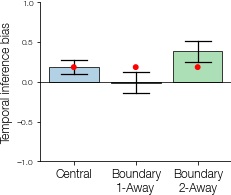

In [8]:
fig, ax = plt.subplots(figsize=(3.5, 3))
colors = figures.get_induct_colors()
# data
sns.barplot(
    data=m,
    x='trial_type',
    y='bias',
    hue='trial_type',
    palette=colors['light'],
    edgecolor='k',
    linewidth=0.75,
    dodge=False,
    capsize=0.425,
    zorder=0,
    ax=ax,
)
# model fit
sns.pointplot(
    data=m,
    x='trial_type',
    y='prob_bias',
    color='r',
    linewidth=0.75,
    dodge=False,
    join=False,
    ci=None,
    zorder=1000,
    ax=ax,
)
plt.setp(ax.lines, zorder=50, linewidth=1.25, color='k', label=None)
plt.setp(ax.collections, zorder=100, label=None)
ax.set(
    ylabel='Temporal inference bias',
    ylim=(-1, 1),
    yticks=np.arange(-1, 1.5, .5),
    xticklabels=['Central', 'Boundary\n1-Away', 'Boundary\n2-Away'],
);
ax.axline((0, 0), slope=0, color='k', linewidth=.75);
ax.spines['left'].set_bounds(-1, 1)
ax.set_xlabel('')
ax.get_legend().remove()
ax.tick_params(axis='x', labelsize='large');
fig.savefig(os.path.join(model_dir, f'induct_mean_fit.pdf'))

In [9]:
%load_ext watermark
%watermark -v -iv

Python implementation: CPython
Python version       : 3.7.6
IPython version      : 7.11.1

pandas    : 1.2.5
seaborn   : 0.11.1
numpy     : 1.18.1
tesser    : 0.1.0
mindstorm : 0.8.1
matplotlib: 3.4.2
pingouin  : 0.3.12

